In [2]:
import torch
import torch.nn as nn
import torch.optim as opt
import torchvision
import torchvision.transforms as transforms

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device : {device}')

device : cuda


In [4]:
trainset = torchvision.datasets.MNIST(root='data',
                                      train=True,
                                      transform=transforms.ToTensor(),
                                      download=True)

testset = torchvision.datasets.MNIST(root='data',
                                     train=False,
                                     transform=transforms.ToTensor(),
                                     download=True)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.54MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.09MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.45MB/s]


In [5]:
# Encoder : Dense(784 -> 128), Dense(128 -> 64), Dense(64 -> 32)
# Decoder : Dense(32 -> 64), Dense(64 -> 128), Dense(128 -> 784)

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784,128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 784)
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded, encoded

In [6]:
class CNNAE(nn.Module):
    def __init__(self):
        super(CNNAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

In [7]:
#model = AE()
model = CNNAE().to(device)
print(model)

CNNAE(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)


In [8]:
loss_fn = nn.MSELoss()
optim = opt.Adam(model.parameters(), lr=0.001)

# Training
epochs = 10

for epoch in range(epochs):
    for data in trainloader:
        inputs, _ = data
        inputs = inputs.to(device)
        #inputs = inputs.view(inputs.size(0), -1)

        optim.zero_grad()

        outputs, _ = model(inputs)
        loss = loss_fn(outputs, inputs)

        loss.backward()
        optim.step()

    print(f'epoch : {epoch}, loss : {loss}')
print('Finish')

epoch : 0, loss : 0.004131826106458902
epoch : 1, loss : 0.0038517427165061235
epoch : 2, loss : 0.003377453424036503
epoch : 3, loss : 0.0032478743232786655
epoch : 4, loss : 0.0031387319322675467
epoch : 5, loss : 0.003037211252376437
epoch : 6, loss : 0.002318187616765499
epoch : 7, loss : 0.002757802838459611
epoch : 8, loss : 0.0021241125650703907
epoch : 9, loss : 0.002465815283358097
Finish


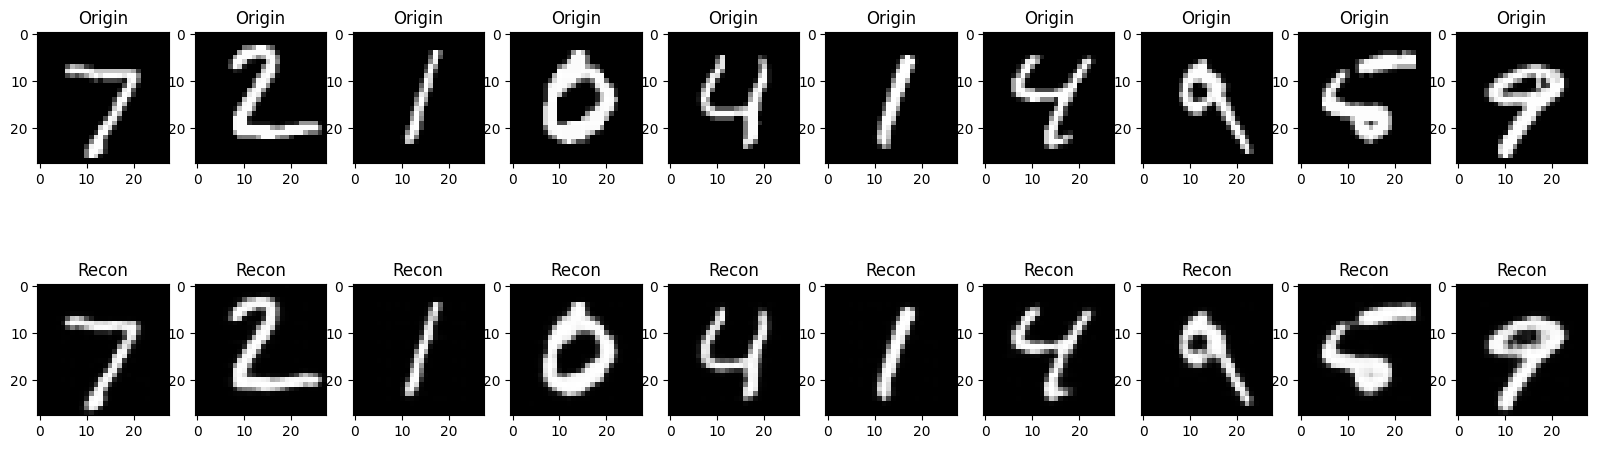

In [9]:
import matplotlib.pyplot as plt
import numpy as np

images, labels = next(iter(testloader))
# images_flat = images.view(images.size(0), -1)

# encoded2 = model.encoder(images_flat.to(device))
# recon_images_flat = model.decoder(encoded2)

recon_images_flat, encoded = model(images.to(device))
recon_images = recon_images_flat.view(images.size())

n_imgs = 10
plt.figure(figsize=(20,6))
for i in range(n_imgs):
    ax = plt.subplot(2, n_imgs, i+1)
    # c, h ,w --> h, w, c --> h, w
    plt.imshow(np.transpose(images[i].numpy(),(1,2,0)).squeeze(), cmap='gray')
    ax.set_title('Origin')

    ax = plt.subplot(2, n_imgs, i + 1 + n_imgs)
    plt.imshow(np.transpose(recon_images[i].detach().cpu().numpy(), (1,2,0)).squeeze(), cmap='gray')
    ax.set_title("Recon")
plt.show()

In [10]:
print(images.size())
print(recon_images_flat.size())
print(recon_images.size())

print(images[0].numpy().shape)

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
(1, 28, 28)


In [11]:
encoded.shape

torch.Size([64, 32, 7, 7])